In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.chdir("../..")


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import json
import time

from tqdm import tqdm


In [38]:
from qml.tools.random import XRandomGenerator


In [4]:
from qml.db import target as xtarget
from qml.db.ml import MLDatasetGenerator

# step 0
from qml.db.ml import MLDatasetGenerator

# step 1
from qml.model.encoding import EncodingUnitManager
from qml.model.model import Model

# step 2
from qml.optimizer import evaluator as xeval

# step 3
from qml.model.unit import UnitManager

# step 4: train candidates
from qml import optimizer as xoptim


In [5]:
class DPODatasetGenerator:

    def __init__(
            self,
            target_function_generator: xtarget.TargetFunctionGenerator,
    ):
        pass


### Procedure de faire la dataset pour OCGTraining

#### parameters
Nc: Number of candidates in single dataset

#### avec Random Units
0. Generate random taget dataset
1. Prepare MQC avec Encoding
2. Calculate Wavelet seriese and loss -> wseries, loss_avons
3. Append candidate units x Nc --> units: json
4. Training candidates
5. Calculate loss --> loss_apres
6. Store into db --> db = db & {wseries, units, loss_apres}

7. repeat step 2 - 5 until loss threashold {threashold_loss} ou max number for repeats {num_iter_elever}

## Parameters

In [6]:
# qmc
num_qubits = 2

# target dataset
db_size = 10
dim_order = 4

# wavelet
wavelet_dim = 4

# candidates
num_gates = 3
num_candidates = 5

# candidate training
max_iter = 20


In [16]:
# db
db_file_name = "dpo_dataset_0.txt"
num_data = 0


### 0. Generate random target dataset

In [17]:
tfun = xtarget.PolynominalTargetFunctionGenerator(dim_order)
tgen = MLDatasetGenerator(tfun)
tdataset = tgen.generate(db_size)


### 1. Prepare MQC

In [18]:
eunit = EncodingUnitManager.AngleEncoding(1, num_qubits, repeat=True)
model = Model(num_qubits, 1, eunit, [], [])


### 2. Calc wavelet seriese and loss

In [32]:
wevaluator = xeval.WaveletEvaluator(xeval.Haar(), tdataset, model, wavelet_dim=wavelet_dim)
wresult = wevaluator()
wresult.powers


array([-0.61655818, -0.71719184,  0.56243874, -0.36459933, -0.28506377,
        0.51359565,  0.05328097, -0.29725074,  0.07888017, -0.22156591,
       -0.03888941,  0.47882589, -0.19242844,  0.06722817,  0.13332276])

### 3. Append candidate units

In [20]:
# generate and append candidate units
uman = UnitManager(num_qubits, num_gates)


In [33]:
# fix previous round trainable unit
model.fix_trainable_units()

def generate_candidate():
    candidate_unit = uman.generate_random_unit(name=f"unit_{uman.num_generated:04}")
    return candidate_unit

candidate_units = [generate_candidate() for _ in range(num_candidates)]
candidate_models = [
    Model(model.nq, 1, model.input_units, model.fixed_units, candidate_unit)
    for candidate_unit in candidate_units
]


### 4. Train candidates

In [34]:
def train_candidate(candidate_model, tdataset):
    train_optimizer = xoptim.LocalSearchOptimizer(tdataset)
    train_result = train_optimizer.optimize(candidate_model, max_iter, verbose=False)
    return train_result

train_results = [
    train_candidate(candidate_model, tdataset)
    for candidate_model in candidate_models
]


### 5. Calc loss apres training

In [35]:
loss_evaluator = xeval.MSEEvaluator(tdataset, model)
lresults = [loss_evaluator(train_result.first.x, candidate_model) for train_result, candidate_model in zip(train_results, candidate_models)]


### 6. Store as db data

In [36]:
data = dict(
    wseries=wresult.powers.tolist(),
    units=[candidate_unit.to_dict() for candidate_unit in candidate_units],
    losses=[float(lresult.loss) for lresult in lresults],
)
with open(db_file_name, mode="a") as f:
    print(json.dumps(data), file=f)


### 7. Update

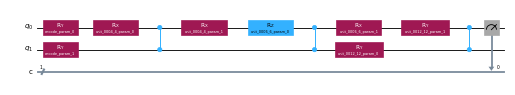

In [37]:
best_model_id = np.argmin(data["losses"])
best_model = candidate_models[best_model_id]
model = best_model

fig, ax = plt.subplots()
model.draw(ax)


In [69]:
class DPODatasetGenerator:

    WAVELET_CLASS = xeval.Haar

    def __init__(
            self,
            num_qubits: int,
            num_gates: int,
            max_order: int,
            max_repeat_for_target: int = 3,
            # step 0
            qml_db_size: int = 50,
            db_filename = "dpo_databsae.txt",
            # step 1
            # step 2
            wavelet_class: xeval.Wavelet = None,
            wavelet_dim: int = 4,
            # step 3
            num_candidates: int = 5,
            # step 4
            qml_max_iter: int = 50,
            qml_batch_size: int = None,
            seed: int = None,
    ) -> None:
        self.rng = rng = XRandomGenerator(seed)
        self.num_qubits = nq = num_qubits
        self.num_gates = ng = num_gates
        self.max_repeat_for_target = max_repeat_for_target

        # step 0 target function
        self.max_order = d = max_order
        self.tfun = xtarget.PolynominalTargetFunctionGenerator(d, rng.new_seed())
        self.tgen = MLDatasetGenerator(self.tfun, rng.new_seed())
        self.qml_db_size = qml_db_size
        self.db_filename = db_filename

        # step 1 prepare mqc

        # step 2 calc wavelet series
        if wavelet_class is None:
            wavelet_class = self.WAVELET_CLASS
        self.wavelet_class = wavelet_class
        self.wavelet_dim = wavelet_dim
        
        # step 3
        self.uman = UnitManager(nq, ng, rng.new_seed())
        self.num_candidates = num_candidates

        # step 4 tain candidate
        self.qml_max_iter = qml_max_iter
        self.qml_batch_size = qml_batch_size
    
    def initialize_qml_and_model(self):
        # step 0 generate qml database
        qml_dataset = self.tgen.generate(self.qml_db_size)

        # step 1 prepare mqc
        eunit = EncodingUnitManager.AngleEncoding(1, self.num_qubits, repeat=True)
        model = Model(self.num_qubits, 1, eunit, [], [])
        
        return qml_dataset, model
    
    def generate(
            self,
            size: int,
            db_filename: str = None,
            batch_size: int = None,
    ):
        if db_filename is None:
            db_filename = self.db_filename
        batch_size = self.qml_batch_size if batch_size is None else batch_size

        num_data = 0
        
        while True:
            print("num_data:", num_data)

            # step 0. generate qml database with target func
            # step 1. prepare mqc
            qml_dataset, model = self.initialize_qml_and_model()

            for _ in range(self.max_repeat_for_target):
                print(f"round:{num_data:>4d}", end="\t")
                # step 2. calc wavelet seriese
                wave_evaluator = xeval.WaveletEvaluator(self.wavelet_class(), qml_dataset, model, wavelet_dim=self.wavelet_dim)
                wave_result = wave_evaluator()

                model.fix_trainable_units()

                loss_results = []
                candidate_units = []
                candidate_models = []
                for _ in tqdm(range(self.num_candidates)):
                    # step 3. append candidate units
                    candidate_unit = self.uman.generate_random_unit()
                    candidate_units.append(candidate_unit)
                    candidate_model = Model(model.nq, 1, model.input_units, model.fixed_units, candidate_unit)
                    candidate_models.append(candidate_model)

                    # step 4. train candidates
                    train_optimizer = xoptim.LocalSearchOptimizer(qml_dataset)
                    train_result = train_optimizer.optimize(
                        candidate_model,
                        self.qml_max_iter,
                        batch_size=batch_size,
                        verbose=False
                    )

                    # step 5. calc loss after training
                    loss_evaluator = xeval.MSEEvaluator(qml_dataset, candidate_model)
                    loss_result = loss_evaluator(train_result.first.x, candidate_model)
                    loss_results.append(loss_result)

                # step 6. store as db
                data = dict(
                    wseries=wave_result.powers.tolist(),
                    units=[candidate_unit.to_dict() for candidate_unit  in candidate_units],
                    losses=[float(loss_result.loss) for loss_result in loss_results],
                )
                print("[info] saving data into:", db_filename)
                with open(db_filename, mode="a") as f:
                    print(json.dumps(data), file=f)
                num_data += 1

                # check generated data size
                if num_data >= size:
                    return db_filename

                # if trained model reaches near-optimal --> create new problem set
                if np.min(data["losses"]) <= 1e-3:
                    break
                
                # update current model
                best_candidate_no = np.argmin(data["losses"])
                model = candidate_models[best_candidate_no]

            

ddgen = DPODatasetGenerator(
    num_qubits, num_gates, dim_order,
    max_repeat_for_target = 3,
    # step 0
    qml_db_size = 50,
    db_filename = "dpo_databsae.txt",
    # step 1
    # step 2
    wavelet_class = None,
    wavelet_dim = 8,
    # step 3
    num_candidates = 5,
    # step 4
    qml_max_iter = 50,
    qml_batch_size=20
)
# ddgen = DPODatasetGenerator(num_qubits, num_gates, dim_order, qml_batch_size=10, qml_max_iter=50)
ddgen.generate(500)


num_data: 0
round:   0	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
round:   1	

100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


[info] saving data into: dpo_databsae.txt
round:   2	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
num_data: 3
round:   3	

100%|██████████| 5/5 [01:30<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round:   4	

100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


[info] saving data into: dpo_databsae.txt
round:   5	

100%|██████████| 5/5 [01:31<00:00, 18.39s/it]


[info] saving data into: dpo_databsae.txt
num_data: 6
round:   6	

100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


[info] saving data into: dpo_databsae.txt
round:   7	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
round:   8	

100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


[info] saving data into: dpo_databsae.txt
num_data: 9
round:   9	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round:  10	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round:  11	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 12
round:  12	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round:  13	

100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


[info] saving data into: dpo_databsae.txt
round:  14	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 15
round:  15	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round:  16	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round:  17	

100%|██████████| 5/5 [01:30<00:00, 18.10s/it]


[info] saving data into: dpo_databsae.txt
num_data: 18
round:  18	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
round:  19	

100%|██████████| 5/5 [01:34<00:00, 18.94s/it]


[info] saving data into: dpo_databsae.txt
round:  20	

100%|██████████| 5/5 [01:36<00:00, 19.39s/it]


[info] saving data into: dpo_databsae.txt
num_data: 21
round:  21	

100%|██████████| 5/5 [01:37<00:00, 19.43s/it]


[info] saving data into: dpo_databsae.txt
round:  22	

100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


[info] saving data into: dpo_databsae.txt
round:  23	

100%|██████████| 5/5 [01:31<00:00, 18.30s/it]


[info] saving data into: dpo_databsae.txt
num_data: 24
round:  24	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round:  25	

100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
round:  26	

100%|██████████| 5/5 [01:32<00:00, 18.44s/it]


[info] saving data into: dpo_databsae.txt
num_data: 27
round:  27	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
round:  28	

100%|██████████| 5/5 [01:32<00:00, 18.43s/it]


[info] saving data into: dpo_databsae.txt
round:  29	

100%|██████████| 5/5 [01:32<00:00, 18.47s/it]


[info] saving data into: dpo_databsae.txt
num_data: 30
round:  30	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
round:  31	

100%|██████████| 5/5 [01:31<00:00, 18.27s/it]


[info] saving data into: dpo_databsae.txt
round:  32	

100%|██████████| 5/5 [01:32<00:00, 18.43s/it]


[info] saving data into: dpo_databsae.txt
num_data: 33
round:  33	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
round:  34	

100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


[info] saving data into: dpo_databsae.txt
round:  35	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 36
round:  36	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round:  37	

100%|██████████| 5/5 [01:30<00:00, 18.10s/it]


[info] saving data into: dpo_databsae.txt
round:  38	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 39
round:  39	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round:  40	

100%|██████████| 5/5 [01:29<00:00, 17.99s/it]


[info] saving data into: dpo_databsae.txt
round:  41	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
num_data: 42
round:  42	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round:  43	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round:  44	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 45
round:  45	

100%|██████████| 5/5 [01:29<00:00, 17.84s/it]


[info] saving data into: dpo_databsae.txt
round:  46	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round:  47	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
num_data: 48
round:  48	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round:  49	

100%|██████████| 5/5 [01:32<00:00, 18.50s/it]


[info] saving data into: dpo_databsae.txt
round:  50	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 51
round:  51	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round:  52	

100%|██████████| 5/5 [01:29<00:00, 17.99s/it]


[info] saving data into: dpo_databsae.txt
round:  53	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
num_data: 54
round:  54	

100%|██████████| 5/5 [01:33<00:00, 18.71s/it]


[info] saving data into: dpo_databsae.txt
round:  55	

100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
round:  56	

100%|██████████| 5/5 [01:31<00:00, 18.23s/it]


[info] saving data into: dpo_databsae.txt
num_data: 57
round:  57	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
round:  58	

100%|██████████| 5/5 [01:31<00:00, 18.35s/it]


[info] saving data into: dpo_databsae.txt
round:  59	

100%|██████████| 5/5 [01:32<00:00, 18.43s/it]


[info] saving data into: dpo_databsae.txt
num_data: 60
round:  60	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
round:  61	

100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
round:  62	

100%|██████████| 5/5 [01:33<00:00, 18.67s/it]


[info] saving data into: dpo_databsae.txt
num_data: 63
round:  63	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
round:  64	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
round:  65	

100%|██████████| 5/5 [01:31<00:00, 18.26s/it]


[info] saving data into: dpo_databsae.txt
num_data: 66
round:  66	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
round:  67	

100%|██████████| 5/5 [01:31<00:00, 18.29s/it]


[info] saving data into: dpo_databsae.txt
round:  68	

100%|██████████| 5/5 [01:32<00:00, 18.40s/it]


[info] saving data into: dpo_databsae.txt
num_data: 69
round:  69	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
round:  70	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round:  71	

100%|██████████| 5/5 [01:30<00:00, 18.08s/it]


[info] saving data into: dpo_databsae.txt
num_data: 72
round:  72	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round:  73	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round:  74	

100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


[info] saving data into: dpo_databsae.txt
num_data: 75
round:  75	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round:  76	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
round:  77	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 78
round:  78	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round:  79	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round:  80	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
num_data: 81
round:  81	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round:  82	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round:  83	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
num_data: 84
round:  84	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round:  85	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round:  86	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
num_data: 87
round:  87	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round:  88	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round:  89	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 90
round:  90	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round:  91	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round:  92	

100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


[info] saving data into: dpo_databsae.txt
num_data: 93
round:  93	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round:  94	

100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


[info] saving data into: dpo_databsae.txt
round:  95	

100%|██████████| 5/5 [01:32<00:00, 18.40s/it]


[info] saving data into: dpo_databsae.txt
num_data: 96
round:  96	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
round:  97	

100%|██████████| 5/5 [01:31<00:00, 18.28s/it]


[info] saving data into: dpo_databsae.txt
round:  98	

100%|██████████| 5/5 [01:32<00:00, 18.41s/it]


[info] saving data into: dpo_databsae.txt
num_data: 99
round:  99	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
round: 100	

100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


[info] saving data into: dpo_databsae.txt
round: 101	

100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 102
round: 102	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 103	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round: 104	

100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


[info] saving data into: dpo_databsae.txt
num_data: 105
round: 105	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 106	

100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


[info] saving data into: dpo_databsae.txt
round: 107	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 108
round: 108	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 109	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 110	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
num_data: 111
round: 111	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 112	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 113	

100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


[info] saving data into: dpo_databsae.txt
num_data: 114
round: 114	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 115	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
round: 116	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
num_data: 117
round: 117	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 118	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
round: 119	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
num_data: 120
round: 120	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 121	

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]


[info] saving data into: dpo_databsae.txt
round: 122	

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]


[info] saving data into: dpo_databsae.txt
num_data: 123
round: 123	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 124	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round: 125	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
num_data: 126
round: 126	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 127	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 128	

100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


[info] saving data into: dpo_databsae.txt
num_data: 129
round: 129	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 130	

100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


[info] saving data into: dpo_databsae.txt
round: 131	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 132
round: 132	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 133	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
round: 134	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 135
round: 135	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 136	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


[info] saving data into: dpo_databsae.txt
round: 137	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 138
round: 138	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 139	

100%|██████████| 5/5 [01:30<00:00, 18.10s/it]


[info] saving data into: dpo_databsae.txt
round: 140	

100%|██████████| 5/5 [01:31<00:00, 18.25s/it]


[info] saving data into: dpo_databsae.txt
num_data: 141
round: 141	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 142	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
round: 143	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 144
round: 144	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 145	

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]


[info] saving data into: dpo_databsae.txt
round: 146	

100%|██████████| 5/5 [01:28<00:00, 17.65s/it]


[info] saving data into: dpo_databsae.txt
num_data: 147
round: 147	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 148	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 149	

100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


[info] saving data into: dpo_databsae.txt
num_data: 150
round: 150	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 151	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 152	

100%|██████████| 5/5 [01:29<00:00, 17.86s/it]


[info] saving data into: dpo_databsae.txt
num_data: 153
round: 153	

100%|██████████| 5/5 [01:29<00:00, 17.83s/it]


[info] saving data into: dpo_databsae.txt
round: 154	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 155	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 156
round: 156	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 157	

100%|██████████| 5/5 [01:30<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 158	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 159
round: 159	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 160	

100%|██████████| 5/5 [01:29<00:00, 17.99s/it]


[info] saving data into: dpo_databsae.txt
round: 161	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
num_data: 162
round: 162	

100%|██████████| 5/5 [01:31<00:00, 18.37s/it]


[info] saving data into: dpo_databsae.txt
round: 163	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 164	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 165
round: 165	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 166	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round: 167	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 168
round: 168	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 169	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round: 170	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
num_data: 171
round: 171	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 172	

100%|██████████| 5/5 [01:30<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 173	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
num_data: 174
round: 174	

100%|██████████| 5/5 [01:28<00:00, 17.64s/it]


[info] saving data into: dpo_databsae.txt
round: 175	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 176	

100%|██████████| 5/5 [01:31<00:00, 18.23s/it]


[info] saving data into: dpo_databsae.txt
num_data: 177
round: 177	

100%|██████████| 5/5 [01:32<00:00, 18.47s/it]


[info] saving data into: dpo_databsae.txt
round: 178	

100%|██████████| 5/5 [01:31<00:00, 18.23s/it]


[info] saving data into: dpo_databsae.txt
round: 179	

100%|██████████| 5/5 [01:32<00:00, 18.42s/it]


[info] saving data into: dpo_databsae.txt
num_data: 180
round: 180	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
round: 181	

100%|██████████| 5/5 [01:33<00:00, 18.63s/it]


[info] saving data into: dpo_databsae.txt
round: 182	

100%|██████████| 5/5 [01:32<00:00, 18.44s/it]


[info] saving data into: dpo_databsae.txt
num_data: 183
round: 183	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
round: 184	

100%|██████████| 5/5 [01:31<00:00, 18.31s/it]


[info] saving data into: dpo_databsae.txt
round: 185	

100%|██████████| 5/5 [01:32<00:00, 18.41s/it]


[info] saving data into: dpo_databsae.txt
num_data: 186
round: 186	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
round: 187	

100%|██████████| 5/5 [01:31<00:00, 18.26s/it]


[info] saving data into: dpo_databsae.txt
round: 188	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
num_data: 189
round: 189	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 190	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 191	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
num_data: 192
round: 192	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 193	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


[info] saving data into: dpo_databsae.txt
round: 194	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 195
round: 195	

100%|██████████| 5/5 [01:31<00:00, 18.30s/it]


[info] saving data into: dpo_databsae.txt
round: 196	

100%|██████████| 5/5 [01:31<00:00, 18.30s/it]


[info] saving data into: dpo_databsae.txt
round: 197	

100%|██████████| 5/5 [01:31<00:00, 18.38s/it]


[info] saving data into: dpo_databsae.txt
num_data: 198
round: 198	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
round: 199	

100%|██████████| 5/5 [01:31<00:00, 18.36s/it]


[info] saving data into: dpo_databsae.txt
round: 200	

100%|██████████| 5/5 [01:32<00:00, 18.43s/it]


[info] saving data into: dpo_databsae.txt
num_data: 201
round: 201	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
round: 202	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


[info] saving data into: dpo_databsae.txt
round: 203	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
num_data: 204
round: 204	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 205	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round: 206	

100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 207
round: 207	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 208	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 209	

100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


[info] saving data into: dpo_databsae.txt
num_data: 210
round: 210	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 211	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 212	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 213
round: 213	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 214	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
round: 215	

100%|██████████| 5/5 [01:31<00:00, 18.27s/it]


[info] saving data into: dpo_databsae.txt
num_data: 216
round: 216	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
round: 217	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
round: 218	

100%|██████████| 5/5 [01:29<00:00, 17.88s/it]


[info] saving data into: dpo_databsae.txt
num_data: 219
round: 219	

100%|██████████| 5/5 [01:29<00:00, 17.80s/it]


[info] saving data into: dpo_databsae.txt
round: 220	

100%|██████████| 5/5 [01:31<00:00, 18.32s/it]


[info] saving data into: dpo_databsae.txt
round: 221	

100%|██████████| 5/5 [01:32<00:00, 18.40s/it]


[info] saving data into: dpo_databsae.txt
num_data: 222
round: 222	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 223	

100%|██████████| 5/5 [01:30<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 224	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
num_data: 225
round: 225	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 226	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
round: 227	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 228
round: 228	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 229	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


[info] saving data into: dpo_databsae.txt
round: 230	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 231
round: 231	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 232	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round: 233	

100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


[info] saving data into: dpo_databsae.txt
num_data: 234
round: 234	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 235	

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]


[info] saving data into: dpo_databsae.txt
round: 236	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
num_data: 237
round: 237	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 238	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
round: 239	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
num_data: 240
round: 240	

100%|██████████| 5/5 [01:29<00:00, 17.85s/it]


[info] saving data into: dpo_databsae.txt
round: 241	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 242	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 243
round: 243	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 244	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 245	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
num_data: 246
round: 246	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 247	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round: 248	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 249
round: 249	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 250	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 251	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
num_data: 252
round: 252	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 253	

100%|██████████| 5/5 [01:30<00:00, 18.08s/it]


[info] saving data into: dpo_databsae.txt
round: 254	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 255
round: 255	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 256	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
round: 257	

100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


[info] saving data into: dpo_databsae.txt
num_data: 258
round: 258	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 259	

100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


[info] saving data into: dpo_databsae.txt
round: 260	

100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


[info] saving data into: dpo_databsae.txt
num_data: 261
round: 261	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 262	

100%|██████████| 5/5 [01:29<00:00, 17.84s/it]


[info] saving data into: dpo_databsae.txt
round: 263	

100%|██████████| 5/5 [01:28<00:00, 17.66s/it]


[info] saving data into: dpo_databsae.txt
num_data: 264
round: 264	

100%|██████████| 5/5 [01:27<00:00, 17.54s/it]


[info] saving data into: dpo_databsae.txt
round: 265	

100%|██████████| 5/5 [01:28<00:00, 17.79s/it]


[info] saving data into: dpo_databsae.txt
round: 266	

100%|██████████| 5/5 [01:31<00:00, 18.23s/it]


[info] saving data into: dpo_databsae.txt
num_data: 267
round: 267	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 268	

100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


[info] saving data into: dpo_databsae.txt
round: 269	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
num_data: 270
round: 270	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 271	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 272	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
num_data: 273
round: 273	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 274	

100%|██████████| 5/5 [01:29<00:00, 17.99s/it]


[info] saving data into: dpo_databsae.txt
round: 275	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 276
round: 276	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 277	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
round: 278	

100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 279
round: 279	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 280	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round: 281	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 282
round: 282	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 283	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
round: 284	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 285
round: 285	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 286	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 287	

100%|██████████| 5/5 [01:28<00:00, 17.66s/it]


[info] saving data into: dpo_databsae.txt
num_data: 288
round: 288	

100%|██████████| 5/5 [01:27<00:00, 17.49s/it]


[info] saving data into: dpo_databsae.txt
round: 289	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 290	

100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 291
round: 291	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 292	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round: 293	

100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


[info] saving data into: dpo_databsae.txt
num_data: 294
round: 294	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 295	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
round: 296	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 297
round: 297	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 298	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 299	

100%|██████████| 5/5 [01:32<00:00, 18.46s/it]


[info] saving data into: dpo_databsae.txt
num_data: 300
round: 300	

100%|██████████| 5/5 [01:31<00:00, 18.23s/it]


[info] saving data into: dpo_databsae.txt
round: 301	

100%|██████████| 5/5 [01:31<00:00, 18.25s/it]


[info] saving data into: dpo_databsae.txt
round: 302	

100%|██████████| 5/5 [01:31<00:00, 18.31s/it]


[info] saving data into: dpo_databsae.txt
num_data: 303
round: 303	

100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
round: 304	

100%|██████████| 5/5 [01:31<00:00, 18.28s/it]


[info] saving data into: dpo_databsae.txt
round: 305	

100%|██████████| 5/5 [01:31<00:00, 18.34s/it]


[info] saving data into: dpo_databsae.txt
num_data: 306
round: 306	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
round: 307	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
round: 308	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
num_data: 309
round: 309	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 310	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
round: 311	

100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


[info] saving data into: dpo_databsae.txt
num_data: 312
round: 312	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 313	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 314	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
num_data: 315
round: 315	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 316	

100%|██████████| 5/5 [01:30<00:00, 18.10s/it]


[info] saving data into: dpo_databsae.txt
round: 317	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 318
round: 318	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 319	

100%|██████████| 5/5 [01:30<00:00, 18.10s/it]


[info] saving data into: dpo_databsae.txt
round: 320	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 321
round: 321	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 322	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round: 323	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 324
round: 324	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 325	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round: 326	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
num_data: 327
round: 327	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 328	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 329	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
num_data: 330
round: 330	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 331	

100%|██████████| 5/5 [01:29<00:00, 17.85s/it]


[info] saving data into: dpo_databsae.txt
round: 332	

100%|██████████| 5/5 [01:28<00:00, 17.65s/it]


[info] saving data into: dpo_databsae.txt
num_data: 333
round: 333	

100%|██████████| 5/5 [01:27<00:00, 17.56s/it]


[info] saving data into: dpo_databsae.txt
round: 334	

100%|██████████| 5/5 [01:28<00:00, 17.63s/it]


[info] saving data into: dpo_databsae.txt
round: 335	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 336
round: 336	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 337	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
round: 338	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 339
round: 339	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 340	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 341	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
num_data: 342
round: 342	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 343	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round: 344	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 345
round: 345	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 346	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 347	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 348
round: 348	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 349	

100%|██████████| 5/5 [01:30<00:00, 18.08s/it]


[info] saving data into: dpo_databsae.txt
round: 350	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
num_data: 351
round: 351	

100%|██████████| 5/5 [01:29<00:00, 17.88s/it]


[info] saving data into: dpo_databsae.txt
round: 352	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
round: 353	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 354
round: 354	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 355	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 356	

100%|██████████| 5/5 [01:28<00:00, 17.77s/it]


[info] saving data into: dpo_databsae.txt
num_data: 357
round: 357	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 358	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round: 359	

100%|██████████| 5/5 [01:30<00:00, 18.08s/it]


[info] saving data into: dpo_databsae.txt
num_data: 360
round: 360	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 361	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
round: 362	

100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 363
round: 363	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 364	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
round: 365	

100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 366
round: 366	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 367	

100%|██████████| 5/5 [01:29<00:00, 17.99s/it]


[info] saving data into: dpo_databsae.txt
round: 368	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
num_data: 369
round: 369	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 370	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
round: 371	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
num_data: 372
round: 372	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 373	

100%|██████████| 5/5 [01:30<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 374	

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]


[info] saving data into: dpo_databsae.txt
num_data: 375
round: 375	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 376	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 377	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
num_data: 378
round: 378	

100%|██████████| 5/5 [01:29<00:00, 17.80s/it]


[info] saving data into: dpo_databsae.txt
round: 379	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 380	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
num_data: 381
round: 381	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 382	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 383	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
num_data: 384
round: 384	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 385	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
round: 386	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
num_data: 387
round: 387	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 388	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 389	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 390
round: 390	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 391	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 392	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


[info] saving data into: dpo_databsae.txt
num_data: 393
round: 393	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 394	

100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


[info] saving data into: dpo_databsae.txt
round: 395	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
num_data: 396
round: 396	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 397	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round: 398	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 399
round: 399	

100%|██████████| 5/5 [01:28<00:00, 17.72s/it]


[info] saving data into: dpo_databsae.txt
round: 400	

100%|██████████| 5/5 [01:28<00:00, 17.62s/it]


[info] saving data into: dpo_databsae.txt
round: 401	

100%|██████████| 5/5 [01:28<00:00, 17.66s/it]


[info] saving data into: dpo_databsae.txt
num_data: 402
round: 402	

100%|██████████| 5/5 [01:27<00:00, 17.53s/it]


[info] saving data into: dpo_databsae.txt
round: 403	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 404	

100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 405
round: 405	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 406	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 407	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
num_data: 408
round: 408	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 409	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 410	

100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


[info] saving data into: dpo_databsae.txt
num_data: 411
round: 411	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 412	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 413	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 414
round: 414	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 415	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 416	

100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 417
round: 417	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 418	

100%|██████████| 5/5 [01:30<00:00, 18.10s/it]


[info] saving data into: dpo_databsae.txt
round: 419	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 420
round: 420	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 421	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
round: 422	

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


[info] saving data into: dpo_databsae.txt
num_data: 423
round: 423	

100%|██████████| 5/5 [01:29<00:00, 17.85s/it]


[info] saving data into: dpo_databsae.txt
round: 424	

100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


[info] saving data into: dpo_databsae.txt
round: 425	

100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


[info] saving data into: dpo_databsae.txt
num_data: 426
round: 426	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 427	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 428	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
num_data: 429
round: 429	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 430	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 431	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
num_data: 432
round: 432	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 433	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 434	

100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


[info] saving data into: dpo_databsae.txt
num_data: 435
round: 435	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 436	

100%|██████████| 5/5 [01:29<00:00, 17.98s/it]


[info] saving data into: dpo_databsae.txt
round: 437	

100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


[info] saving data into: dpo_databsae.txt
num_data: 438
round: 438	

100%|██████████| 5/5 [01:29<00:00, 17.90s/it]


[info] saving data into: dpo_databsae.txt
round: 439	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 440	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
num_data: 441
round: 441	

100%|██████████| 5/5 [01:29<00:00, 17.89s/it]


[info] saving data into: dpo_databsae.txt
round: 442	

100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


[info] saving data into: dpo_databsae.txt
round: 443	

100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


[info] saving data into: dpo_databsae.txt
num_data: 444
round: 444	

100%|██████████| 5/5 [01:29<00:00, 17.89s/it]


[info] saving data into: dpo_databsae.txt
round: 445	

100%|██████████| 5/5 [01:29<00:00, 17.88s/it]


[info] saving data into: dpo_databsae.txt
round: 446	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
num_data: 447
round: 447	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 448	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 449	

100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


[info] saving data into: dpo_databsae.txt
num_data: 450
round: 450	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 451	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


[info] saving data into: dpo_databsae.txt
round: 452	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 453
round: 453	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 454	

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]


[info] saving data into: dpo_databsae.txt
round: 455	

100%|██████████| 5/5 [01:30<00:00, 18.06s/it]


[info] saving data into: dpo_databsae.txt
num_data: 456
round: 456	

100%|██████████| 5/5 [01:30<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 457	

100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


[info] saving data into: dpo_databsae.txt
round: 458	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


[info] saving data into: dpo_databsae.txt
num_data: 459
round: 459	

100%|██████████| 5/5 [01:29<00:00, 17.95s/it]


[info] saving data into: dpo_databsae.txt
round: 460	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 461	

100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


[info] saving data into: dpo_databsae.txt
num_data: 462
round: 462	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 463	

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


[info] saving data into: dpo_databsae.txt
round: 464	

100%|██████████| 5/5 [01:30<00:00, 18.08s/it]


[info] saving data into: dpo_databsae.txt
num_data: 465
round: 465	

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


[info] saving data into: dpo_databsae.txt
round: 466	

100%|██████████| 5/5 [01:30<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 467	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
num_data: 468
round: 468	

100%|██████████| 5/5 [01:27<00:00, 17.53s/it]


[info] saving data into: dpo_databsae.txt
round: 469	

100%|██████████| 5/5 [01:27<00:00, 17.58s/it]


[info] saving data into: dpo_databsae.txt
round: 470	

100%|██████████| 5/5 [01:28<00:00, 17.63s/it]


[info] saving data into: dpo_databsae.txt
num_data: 471
round: 471	

100%|██████████| 5/5 [01:27<00:00, 17.55s/it]


[info] saving data into: dpo_databsae.txt
round: 472	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


[info] saving data into: dpo_databsae.txt
round: 473	

100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


[info] saving data into: dpo_databsae.txt
num_data: 474
round: 474	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 475	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 476	

100%|██████████| 5/5 [01:30<00:00, 18.08s/it]


[info] saving data into: dpo_databsae.txt
num_data: 477
round: 477	

100%|██████████| 5/5 [01:29<00:00, 17.96s/it]


[info] saving data into: dpo_databsae.txt
round: 478	

100%|██████████| 5/5 [01:30<00:00, 18.02s/it]


[info] saving data into: dpo_databsae.txt
round: 479	

100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


[info] saving data into: dpo_databsae.txt
num_data: 480
round: 480	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 481	

100%|██████████| 5/5 [01:30<00:00, 18.15s/it]


[info] saving data into: dpo_databsae.txt
round: 482	

100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


[info] saving data into: dpo_databsae.txt
num_data: 483
round: 483	

100%|██████████| 5/5 [01:29<00:00, 17.92s/it]


[info] saving data into: dpo_databsae.txt
round: 484	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 485	

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


[info] saving data into: dpo_databsae.txt
num_data: 486
round: 486	

100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


[info] saving data into: dpo_databsae.txt
round: 487	

100%|██████████| 5/5 [01:29<00:00, 17.99s/it]


[info] saving data into: dpo_databsae.txt
round: 488	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
num_data: 489
round: 489	

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


[info] saving data into: dpo_databsae.txt
round: 490	

100%|██████████| 5/5 [01:29<00:00, 18.00s/it]


[info] saving data into: dpo_databsae.txt
round: 491	

100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


[info] saving data into: dpo_databsae.txt
num_data: 492
round: 492	

100%|██████████| 5/5 [01:29<00:00, 17.83s/it]


[info] saving data into: dpo_databsae.txt
round: 493	

100%|██████████| 5/5 [01:28<00:00, 17.66s/it]


[info] saving data into: dpo_databsae.txt
round: 494	

100%|██████████| 5/5 [01:28<00:00, 17.61s/it]


[info] saving data into: dpo_databsae.txt
num_data: 495
round: 495	

100%|██████████| 5/5 [01:28<00:00, 17.68s/it]


[info] saving data into: dpo_databsae.txt
round: 496	

100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


[info] saving data into: dpo_databsae.txt
round: 497	

100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


[info] saving data into: dpo_databsae.txt
num_data: 498
round: 498	

100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[info] saving data into: dpo_databsae.txt
round: 499	

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]

[info] saving data into: dpo_databsae.txt


'dpo_databsae.txt'